In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
from lxml import etree
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from gensim.models import Word2Vec

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Word2Vec 실습

## 불용어 제거

In [0]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [4]:
def remove_stopWords(corpus):
  stopWords = ["is", "a", "will", "be"]
  res = []
  for text in corpus:
    temp = text.split(" ")
    for sw in stopWords:
      if sw in temp:    # stopword가 있으면
        temp.remove(sw)
    res.append(" ".join(temp))
  return res

corpus = remove_stopWords(corpus)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

## Vocabulary 만들기

In [5]:
words = []

for text in corpus:
  for word in text.split(" "):
    words.append(word)

words = set(words)    # set함수: 중복 제거 & 알파벳 순서로 정렬
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

## 각 단어를 숫자로

In [7]:
word2int = {}    # 각 단어들을 integer로 저장하는 리스트

for i, word in enumerate(words):
  word2int[word] = i

word2int

{'boy': 9,
 'girl': 3,
 'king': 5,
 'man': 8,
 'pretty': 0,
 'prince': 6,
 'princess': 2,
 'queen': 11,
 'strong': 10,
 'wise': 7,
 'woman': 4,
 'young': 1}

## 입력 데이터 만들기

In [8]:
sentences = []

for sentence in corpus:
  sentences.append(sentence.split(" "))

sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [11]:
window_size = 2
data = []

for sentence in sentences:
  for idx, word in enumerate(sentence):
    for neighbor in sentence[max(idx-window_size, 0):min(idx+window_size, len(sentence))+1]:
      if neighbor != word:
        data.append([word, neighbor])

print(data)    # [[입력, 출력], [입력, 출력], [입력, 출력], ...]

[['king', 'strong'], ['king', 'man'], ['strong', 'king'], ['strong', 'man'], ['man', 'king'], ['man', 'strong'], ['queen', 'wise'], ['queen', 'woman'], ['wise', 'queen'], ['wise', 'woman'], ['woman', 'queen'], ['woman', 'wise'], ['boy', 'young'], ['boy', 'man'], ['young', 'boy'], ['young', 'man'], ['man', 'boy'], ['man', 'young'], ['girl', 'young'], ['girl', 'woman'], ['young', 'girl'], ['young', 'woman'], ['woman', 'girl'], ['woman', 'young'], ['prince', 'young'], ['prince', 'king'], ['young', 'prince'], ['young', 'king'], ['king', 'prince'], ['king', 'young'], ['princess', 'young'], ['princess', 'queen'], ['young', 'princess'], ['young', 'queen'], ['queen', 'princess'], ['queen', 'young'], ['man', 'strong'], ['strong', 'man'], ['woman', 'pretty'], ['pretty', 'woman'], ['prince', 'boy'], ['prince', 'king'], ['boy', 'prince'], ['boy', 'king'], ['king', 'prince'], ['king', 'boy'], ['princess', 'girl'], ['princess', 'queen'], ['girl', 'princess'], ['girl', 'queen'], ['queen', 'princess']

In [0]:
import pandas as pd

In [13]:
for text in corpus:
  print(text)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [14]:
df = pd.DataFrame(data, columns=["input", "label"])
df

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


## 원핫인코딩 (입/출력 단어)

In [17]:
one_hot_dim = len(words)
one_hot_dim

12

In [0]:
import numpy as np

In [0]:
def to_one_hot_encoding(data_point_index):
  one_hot_encoding = np.zeros(one_hot_dim)
  one_hot_encoding[data_point_index] = 1
  return one_hot_encoding

X = []    # input word
Y = []    # target word

for x, y in zip(df["input"], df["label"]):
  X.append(to_one_hot_encoding(word2int[x]))
  Y.append(to_one_hot_encoding(word2int[y]))

# tensorflow에서는 list가 아니라 array를 사용해야 하므로 바꿔준다
xtrain = np.asarray(X)
ytrain = np.asarray(Y)

## 텐서플로우 신경망 구성

In [0]:
import tensorflow as tf

### 그래프 정의

In [0]:
x = tf.placeholder(tf.float32, [None, one_hot_dim])
y = tf.placeholder(tf.float32, [None, one_hot_dim])
EMBEDDING_DIM = 2    # 2차원 워드임베딩 벡터를 생성하려 한다

# input layer -> hidden layer
w1 = tf.Variable(tf.random_normal([one_hot_dim, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1]))

# hidden layer 구성
hidden_layer = tf.add(tf.matmul(x, w1), b1)

# hidden layer -> output layer
w2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, one_hot_dim]))
b2 = tf.Variable(tf.random_normal([1]))

# output layer 구성
hf = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, w2), b2))

cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(hf), 1))
train = tf.train.GradientDescentOptimizer(0.05).minimize(cost)

### 트레이닝

In [33]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

iteration = 30000

for i in range(iteration):
  sess.run(train, feed_dict={x:xtrain, y:ytrain})
  if i % 1000 == 0:
    print("iteration: ", str(i), ", cost: ", sess.run(cost, feed_dict={x:xtrain, y:ytrain}))

iteration:  0 , cost:  3.4818845
iteration:  1000 , cost:  1.9972528
iteration:  2000 , cost:  1.8333732
iteration:  3000 , cost:  1.762527
iteration:  4000 , cost:  1.7371284
iteration:  5000 , cost:  1.7217357
iteration:  6000 , cost:  1.7104707
iteration:  7000 , cost:  1.7016094
iteration:  8000 , cost:  1.6944175
iteration:  9000 , cost:  1.6884593
iteration:  10000 , cost:  1.6834284
iteration:  11000 , cost:  1.6790963
iteration:  12000 , cost:  1.675297
iteration:  13000 , cost:  1.671912
iteration:  14000 , cost:  1.6688561
iteration:  15000 , cost:  1.666068
iteration:  16000 , cost:  1.6635036
iteration:  17000 , cost:  1.661129
iteration:  18000 , cost:  1.6589191
iteration:  19000 , cost:  1.6568557
iteration:  20000 , cost:  1.6549232
iteration:  21000 , cost:  1.6531105
iteration:  22000 , cost:  1.6514075
iteration:  23000 , cost:  1.6498058
iteration:  24000 , cost:  1.648297
iteration:  25000 , cost:  1.6468735
iteration:  26000 , cost:  1.645528
iteration:  27000 , c

## Word2Vec

In [35]:
vectors = sess.run(hidden_layer, feed_dict={x:xtrain, y:ytrain})
print(vectors.shape)
print(vectors)

(52, 2)
[[-0.8156092  -0.24031046]
 [-0.8156092  -0.24031046]
 [-1.8129485   3.7202148 ]
 [-1.8129485   3.7202148 ]
 [-4.4824653  -1.4991225 ]
 [-4.4824653  -1.4991225 ]
 [ 0.7197737  -0.599241  ]
 [ 0.7197737  -0.599241  ]
 [ 4.0812893   0.33585235]
 [ 4.0812893   0.33585235]
 [ 0.52985674 -0.5819524 ]
 [ 0.52985674 -0.5819524 ]
 [-0.87092894 -0.21696675]
 [-0.87092894 -0.21696675]
 [ 0.1327996   0.59190255]
 [ 0.1327996   0.59190255]
 [-4.4824653  -1.4991225 ]
 [-4.4824653  -1.4991225 ]
 [ 1.4152491  -1.1639365 ]
 [ 1.4152491  -1.1639365 ]
 [ 0.1327996   0.59190255]
 [ 0.1327996   0.59190255]
 [ 0.52985674 -0.5819524 ]
 [ 0.52985674 -0.5819524 ]
 [-6.683531   -2.0678728 ]
 [-6.683531   -2.0678728 ]
 [ 0.1327996   0.59190255]
 [ 0.1327996   0.59190255]
 [-0.8156092  -0.24031046]
 [-0.8156092  -0.24031046]
 [ 5.241518   -4.4653783 ]
 [ 5.241518   -4.4653783 ]
 [ 0.1327996   0.59190255]
 [ 0.1327996   0.59190255]
 [ 0.7197737  -0.599241  ]
 [ 0.7197737  -0.599241  ]
 [-4.4824653  -1.499

In [36]:
vectors = sess.run(w1+b1)
print(vectors)

[[ 1.9224182   3.8781767 ]
 [ 0.1327996   0.59190255]
 [ 5.241518   -4.4653783 ]
 [ 1.4152491  -1.1639365 ]
 [ 0.52985674 -0.5819524 ]
 [-0.8156092  -0.24031046]
 [-6.683531   -2.0678728 ]
 [ 4.0812893   0.33585235]
 [-4.4824653  -1.4991225 ]
 [-0.87092894 -0.21696675]
 [-1.8129485   3.7202148 ]
 [ 0.7197737  -0.599241  ]]


In [38]:
w2v_df = pd.DataFrame(vectors, columns=["v1", "v2"])
w2v_df["word"] = words
w2v_df = w2v_df[["word", "v1", "v2"]]
w2v_df

,word,v1,v2
0,pretty,1.922418,3.878177
1,young,0.132800,0.591903
2,princess,5.241518,-4.465378
3,girl,1.415249,-1.163936
4,woman,0.529857,-0.581952
5,king,-0.815609,-0.240310
6,prince,-6.683531,-2.067873
7,wise,4.081289,0.335852
8,man,-4.482465,-1.499123
9,boy,-0.870929,-0.216967


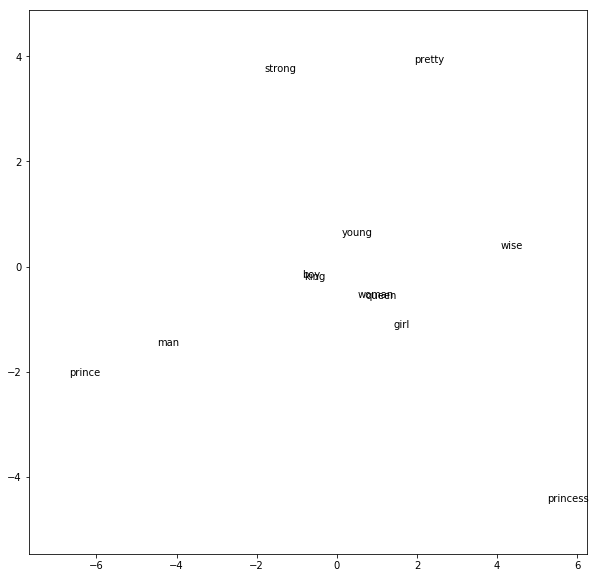

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for word, v1, v2 in zip(w2v_df["word"], w2v_df["v1"], w2v_df["v2"]):
  ax.annotate(word, (v1, v2))

padding = 1.0
x_min = np.amin(vectors, axis=0)[0] - padding
y_min = np.amin(vectors, axis=0)[1] - padding
x_max = np.amax(vectors, axis=0)[0] + padding
y_max = np.amax(vectors, axis=0)[1] + padding

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

# gensim 설치

In [45]:
!pip install gensim

# XML 파일로 Word2Vec 연습

In [0]:
import re
from lxml import etree
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

In [64]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [49]:
targetXml = open("/content/drive/My Drive/190000 멀티캠퍼스/Data/ted_en-20160408.xml", "r")
targetXml

<_io.TextIOWrapper name='/content/drive/My Drive/190000 멀티캠퍼스/Data/ted_en-20160408.xml' mode='r' encoding='UTF-8'>

In [50]:
target_text = etree.parse(targetXml)
target_text

In [0]:
# target_text.xpath("//content/text()")    # content 태그 안의 텍스트를 가져와라. <content> ~ </content> 의 내용을 추출.
parse_text = '\n'.join(target_text.xpath("//content/text()"))

In [0]:
content_text = re.sub("\([^)]*\)", "", parse_text)

In [0]:
sent_text = sent_tokenize(content_text)

In [66]:
len(sent_text)

273424

In [0]:
import string

In [0]:
#구두점 제거, 대문자 -> 소문자

normalized_text = []

for s in sent_text:
  tokens = re.sub("[^a-z0-9]+", " ", s.lower())
  normalized_text.append(tokens)

In [73]:
normalized_text[:10]

['here are two reasons companies fail they only do more of the same or they only do what s new ',
 'to me the real real solution to quality growth is figuring out the balance between two activities exploration and exploitation ',
 'both are necessary but it can be too much of a good thing ',
 'consider facit ',
 'i m actually old enough to remember them ',
 'facit was a fantastic company ',
 'they were born deep in the swedish forest and they made the best mechanical calculators in the world ',
 'everybody used them ',
 'and what did facit do when the electronic calculator came along ',
 'they continued doing exactly the same ']

In [0]:
res = []
res = [word_tokenize(sent) for sent in normalized_text]

In [75]:
print(res[:10])

[['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new'], ['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation'], ['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing'], ['consider', 'facit'], ['i', 'm', 'actually', 'old', 'enough', 'to', 'remember', 'them'], ['facit', 'was', 'a', 'fantastic', 'company'], ['they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world'], ['everybody', 'used', 'them'], ['and', 'what', 'did', 'facit', 'do', 'when', 'the', 'electronic', 'calculator', 'came', 'along'], ['they', 'continued', 'doing', 'exactly', 'the', 'same']]


In [0]:
from gensim.models import Word2Vec

In [0]:
model = Word2Vec(sentences=res, size=100, window=5, min_count=10, sg=0, workers=4)

In [77]:
model.wv.most_similar("reasons")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('reason', 0.6886449456214905),
 ('examples', 0.5870818495750427),
 ('instance', 0.5691580772399902),
 ('questions', 0.5356903076171875),
 ('advantages', 0.5317002534866333),
 ('explanations', 0.5259801745414734),
 ('exceptions', 0.520626425743103),
 ('moments', 0.5163185000419617),
 ('example', 0.5131781101226807),
 ('lessons', 0.5128253698348999)]

In [0]:
model.init_sims(replace=True)    # 메모리 해제

In [79]:
model.similarity("boy", "man")    # 유사도 계산

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.759579

In [80]:
# 예: she+(actor-actress)=he
model.wv.most_similar(positive=["she", "actor"], negative="actress", topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('themselves', 0.34019607305526733),
 ('everyday', 0.3381081223487854),
 ('their', 0.32349908351898193),
 ('fathers', 0.31228339672088623),
 ('countless', 0.3001635670661926)]

# nltk movie reviews

In [81]:
nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [0]:
from nltk.corpus import movie_reviews

In [0]:
sentences = [list(s) for s in movie_reviews.sents()]

In [84]:
len(sentences)

71532

# RNN 이용해 주식 예측

## 데이터 전처리

In [87]:
xy = np.loadtxt("/content/drive/My Drive/190000 멀티캠퍼스/Data/TSLA.csv", delimiter=",", skiprows=1)
xy

# 참고: 순서를 역순으로 뒤집고 싶다면 xy = xy[::-1]

array([[3.18000000e+02, 3.22440002e+02, 3.08809998e+02, 1.30793000e+07,
        3.19269989e+02],
       [3.18410004e+02, 3.18880005e+02, 3.11190002e+02, 7.64910000e+06,
        3.11859985e+02],
       [3.10269989e+02, 3.11850006e+02, 3.03690002e+02, 7.44740000e+06,
        3.05010010e+02],
       ...,
       [2.22009995e+02, 2.23220001e+02, 2.17600006e+02, 7.79430000e+06,
        2.20830002e+02],
       [2.22800003e+02, 2.25399994e+02, 2.18220001e+02, 6.55900000e+06,
        2.22149994e+02],
       [2.19970001e+02, 2.21169998e+02, 2.11000000e+02, 8.53860000e+06,
        2.11399994e+02]])

In [88]:
len(xy)

250

In [0]:
def MinMaxScaler(data):
  # np.max(data, 0)    # axis를 0으로 주면 열단위로 최대값을 구한다
  numerator = data - np.min(data, 0)    # 분자
  denominator = np.max(data, 0) - np.min(data, 0)    # 분모
  return numerator/denominator

In [0]:
seq_length = 7

train_size = int(len(xy)*0.7)    # 175
train_set = xy[0:train_size]    # 0~174
test_set = xy[train_size-seq_length:]    # 168~250
# test_set에서 train_size에서 seq_length를 빼는 이유는, seq_length만큼의 데이터가 예측에 필요하기 때문이다.
# 예를 들어, 0일~6일까지의 데이터로 7일째의 데이터를 예측하고, 1일~7일까지의 데이터로 8일째의 데이터를 예측한다.
# 그러므로 175일째의 데이터는 175-7일~175-1일 (6일간) 의 데이터로 예측할 수 있기 때문에 train_size에서 seq_length를 뺀다.

data_dim = 5    # input_dim
hidden_dim = 10    # 임의의 수 아무거나 주면 된다
learning_rate = 0.01
iterations = 500
output_dim = 1

train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

In [0]:
def build_dataset(time_series, seq_length):
  dataX = []
  dataY = []
  
  for i in range(0, len(time_series)-seq_length):    # range(0, 168) => 0~167
    _x = time_series[i:i+seq_length, :]    # 일주일 data
    _y = time_series[i+seq_length, [-1]]    # 다음날(일주일+1일)의 종가(close)
    # print(_x, " -> ", _y)
    dataX.append(_x)
    dataY.append(_y)
  return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

## 모델 생성

In [0]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, seq_length, data_dim])
y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
yhat = tf.contrib.layers.fully_connected(outputs[:,-1], output_dim, activation_fn=None)

cost = tf.reduce_sum(tf.square(yhat-y))
train = tf.train.AdamOptimizer(learning_rate).minimize(cost)

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

step:0, cost:53.536590576171875
step:1, cost:24.07277488708496
step:2, cost:5.926081657409668
step:3, cost:3.678895950317383
step:4, cost:12.176826477050781
step:5, cost:14.656869888305664
step:6, cost:11.209443092346191
step:7, cost:6.576702117919922
step:8, cost:3.464700698852539
step:9, cost:2.4028024673461914
step:10, cost:2.786548376083374
step:11, cost:3.7829251289367676
step:12, cost:4.762503623962402
step:13, cost:5.383798122406006
step:14, cost:5.536532402038574
step:15, cost:5.260713577270508
step:16, cost:4.680001258850098
step:17, cost:3.9536290168762207
step:18, cost:3.241513967514038
step:19, cost:2.6771035194396973
step:20, cost:2.34550142288208
step:21, cost:2.2684431076049805
step:22, cost:2.401137590408325
step:23, cost:2.646393060684204
step:24, cost:2.886305332183838
step:25, cost:3.0221478939056396
step:26, cost:3.005809783935547
step:27, cost:2.8489129543304443
step:28, cost:2.607895851135254
step:29, cost:2.3555545806884766
step:30, cost:2.153482437133789
step:31

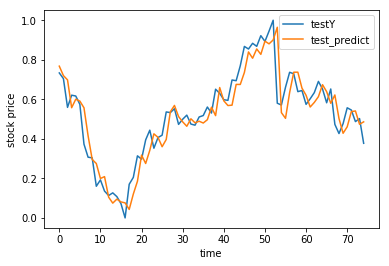

In [103]:
%matplotlib inline

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  # 모델 학습
  for i in range(iterations):
    _, cv = sess.run([train, cost], feed_dict={x:trainX, y:trainY})
    print("step:{}, cost:{}".format(i, cv))
  # 테스트
  test_predict = sess.run(yhat, feed_dict={x:testX})
  rmse_val = sess.run(rmse, feed_dict={targets:testY, predictions:test_predict})
  print("rmse: {}".format(rmse_val))
  plt.plot(testY, label="testY")
  plt.plot(test_predict, label="test_predict")
  plt.legend()
  plt.xlabel("time")
  plt.ylabel("stock price")
  plt.show()